# Chapter 5: Causal Structure Learning from Data

In the previous chapter, we build a causal model knowing the equation structure of the problem from our domain knowledge. However, we do not have the privilege of knowing causal structure in the real world.
In this chapter, our goal is to create a causal model without knowing the causal structure of the problem. In other words, our problem is **causal structure identification or discovery**.

- **With structure learning, we want to determine the structure of the graph that best captures the causal dependencies between the variables in a data set.** 
- In other words, given a dataset, we derive a causal model that describes it.


## How can we estimate the causal structure from a dataset?

Unfortunately, there is no standard recipe for that, and that's why the causal inference is generally challenging. Causal discovery is an example of an inverse problem. 

The usual approach to solving inverse problems is to **make assumptions** about what we are trying to investigate. This narrows down the possible solutions and hopefully makes the problem solvable. 

Remember that there are four common assumptions made across causal discovery algorithms. 

- **Acyclicity** — causal structure can be represented by a DAG $G$ (mentioned in [Chapter 3](/lectures/CH-3-Graphical-Causal-Models.ipynb))
- **Markov Property** — all nodes are independent of their non-descendants when conditioned on their parents (mentioned in [Chapter 3](/lectures/CH-3-Graphical-Causal-Models.ipynb))
- **Faithfulness** — all conditional independences in true underlying distribution $p$ are represented in $G$ 
- **Sufficiency** — any pair of nodes in $G$ has no common external cause


A comprehensive discussion of these causal assumptions is availabe  in [Kalainathan et al., 2018]( https://arxiv.org/abs/1803.04929)

<br/><br/>




While there is a large pool of different methods available (and it is still an active field of ongoing research), all these different structure learning techniques can be generally divided into two main groups:  **Independence-Based Methods** and **Score-Based Methods**

### A. Independence-Based Methods

Independence-based methods assume that the distribution is faithful to the underlying DAG. In orher workds, there is a one-to-one correspondence between d-separationsin the graph and conditional independences in the distribution of the data.  Any query of a d-separation statement can therefore be answered by checking the corresponding conditional independence test.  Inductive causation (IC) algorithm, the
SGS algorithm, and the PC algorithm (named after Peter Spirtes and Clark Glymour) are famous independence-test based algorithms. 

The figure below summarizes the approach for the identification of causal structures. Independence-based methods test for conditional independences in the data;
these properties are related to the graph structure by the Markov condition and faithfulness. However,often the graph is not uniquely identifiable; the method may therefore output different
graphs $G$ and $G'$.

![img](img/ch6/independence_tests.png)

Most independence-based methods first estimate the skeleton, that is, the undirected edges, and orient as many edges as possible afterward.

#### Estimation of the skeleton

The following two statements hold:

- Two nodes $X,Y$ in a DAG $(\mathbf{X},\mathcal{E})$ are adjacent if and only if they cannot be d-separated by any subset $S \in \mathbf{V} \ {X,Y}$.
- If two nodes $X,Y$ in a DAG $(\mathbf{X},\mathcal{E})$ are not adjacent, then they are d-separated by either $\mathbf{Pa}_X$ or $\mathbf{Pa}_Y$.

It follows that if two variables are always dependent, no matter what other variables one conditions on, these two variables must be adjacent (i.e., an edge must connect them).

#### Orientation of Edges

After the skeleton is built, if two nodes are not directly connected in the obtained skeleton, there is a set that d-separates these nodes. 
Suppose that the skeleton contains the structure $X - Z - Y$ with no direct edge between $X$ and $$. Further, let $A$ be a set that d-separates $X$ and $Y$. The structure $X - Z - Y$ is
an immorality and can therefore be oriented as $X → Z ← Y$ if and only if $Z \notin A$.
After the orientation of immoralities, further edges are oriented in order to avoid cycles.

<br>

An outline of the PC algorithm is illustrated in the figure below (image taken from https://towardsdatascience.com/causal-discovery-6858f9af6dcb). 

![img](img/ch6/Trick1.png)


**Step 1:** form a fully connected, undirected graph using every variable in the dataset. 

**Step 2:**  edges are deleted if the corresponding variables are independent. 

**Step 3:**  connected edges undergo conditional independence testing, e.g., independence test of bottom and far-right node conditioned on the middle node (see step 2). If conditioning on a variable kills the dependence, that variable is added to the Separation set for those two variables. Depending on the size of the graph, conditional independence testing will continue (i.e. condition on more variables) until there are no more candidates for testing.

**Step 4:**  colliders (i.e. $X \rightarrow Y \leftarrow Z$) are oriented based on the Separation set of node pairs. 

**Step 5:**  remaining edges are directed based on two constraints, 1) no new v-structures and 2) no directed cycles can be formed.

### B. Score-based Methods

In the preceding section we have directly used the independence statements to infer the graph. Alternatively, we can test different graph structures in their ability to
fit the data. The idea is that graph structures encoding the wrong conditional independences, for example, will yield bad model fits.

#### Best Scoring Graph  

Given data $\mathcal{D} = (X^1,\dots,X^n)$ from a vector $X$ of variables (e.g., a sample containing $n$ i.i.d. observations), the idea is to assign a score $S(\mathcal{D},\mathcal{G})$ to each graph $G$ and search over the space of DAGs to find the graph with the highest score:

$$\hat{ \mathcal{D} } = argmax_{\mathcal{G} DAG over \mathbf{X}} S(\mathcal{D},\mathcal{G})$$

There are several possibilities to define such a scoring function $S$. Often a parametric model is assumed, for example linear Gaussian equations or multinomial distributions which introduces a set of parameters $\theta$.

Here listed are some common functions or approaches used.

**(Penalized) Likelihood:**  

For each graph we may consider the maximum likelihood estimator $\hat{\theta}$ for $\theta$ and then define a score function by the BIC: 

$$ S(\mathcal{D},\mathcal{G}) = \log p(\mathcal{D}|\hat{\theta}, \mathcal{g}) - \frac{\# parameters}{2} \log n $$ 

where $\log p(\mathcal{D}|\hat{\theta}, \mathcal{G})$ is the log likelihood and n is the sample size.

**Bayesian Scoring Functions:** 

We define priors $p_{pr}(G)$ and $p_{pr}(\theta)$ over DAGs and parameters, respectively, and consider the log posterior as a score function (note that $p(\mathcal{D})$ is constant over all DAGs):

$$ S(\mathcal{D},\mathcal{G}) := \log p (\mathcal{D},\mathcal{G}) \propto \log p_{pr}(\mathcal{G}) + \log p(\mathcal{D}|\mathcal{G})$$ 

where $\log p(\mathcal{D}|\mathcal{G})$ is the marginal likelihood.

In the case of parametric models, we call two graphs $G_1$ and $G_2$ distribution equivalent if for each parameter $\theta_1$ there is a corresponding parameter $\theta_2$, such that the distribution obtained from $G_1$ in combination with θ1 is the same as the distribution obtained from graph $G_1$ with $\theta_2$, and vice versa. 
It can be shown that in the linear Gaussian case, for example, two graphs are distribution equivalent if and only if they are Markov equivalent. 


#### Greedy Search Techniques

The search space of all DAGs is growing superexponentially in the number of variables. In general, finding the optimal scoring DAG is a NP-hard problem. 
Just to have an idea, , the numbers of DAGs for 2, 3, 4, and 10 variables are 3, 25, 543, and 4175098976430598143, respectively.
Therefore, it is evident that computing an exact solution that maximize the score $S(\mathcal{D},\mathcal{G})$ by searching over all graphs is often infeasible. 

Instead, greedy search algorithms can be applied.

A greedy algorithm is an approach for solving a problem by selecting the best option available at the moment. 

- greedy algorithms doesn't worry whether the current best result will bring the globally optimal result. The algorithm never reverses the earlier decision, even if the choice is wrong. 

- Usually, greedy algorithms are easier to describe and can perform quite well than other algorithms. However, greedy searches cannot guarantee an optimal solution. 

- For most problems, the space of possible DAGs is so big that finding a true optimal solution is challenging.

- The **Greedy Equivalence Search (GES)** algorithm uses this trick. GES starts with an empty graph and iteratively adds directed edges such that the improvement in a model fitness measure (i.e., score) is maximized.



### C. Other tricks

Often, some additional tricks are used.  
A fundamental property of causality is **asymmetry**. $A$ could cause $B$, but $B$ may not cause $A$. Thus, some algorithms leverage this idea to select between causal model candidates concerning time.
Time asymmetry is quite natural since causes happen before effects. This is used in the **Granger causality test** too. Granger causality test says that a variable $X$ that evolves over time causes another evolving variable $Y$ if predictions of the value of $Y$ based on its own past values and based on the past values of $X$ are better than predictions of $Y$ based only on $ Y$'s own past values.


**Neural networks** have been used to explore causal relationships. Following are two examples:

- Causal Generative Neural Networks (CGNN), where the algorithm learns functional causal models from observational data based on generative neural networks. [CGNN](https://arxiv.org/pdf/1711.08936.pdf)

- Casual Recurrent Neural Networks (CRNN), where we developed a framework to explore causal structure in a multivariate time-series problem. [CRNN](https://ieeexplore.ieee.org/abstract/document/8437162)

A broad overview of different causal structure search methods is available at:
[Review of Causal Discovery Methods Based on Graphical Models](https://www.frontiersin.org/articles/10.3389/fgene.2019.00524/full#:~:text=Causal%20discovery%20aims%20to%20find,process%20or%20the%20sampling%20process)

We also recommend you to check Chapter 4 and 7, Learning Cause-Effect Models from the [Elements of Causal Inference](https://mitpress.mit.edu/books/elements-causal-inference) book.

Finally, **structure learning is an active field of research.** These algorithms don't guarantee to retrieve the true causal relationship for all the variables. However, they can help better understand the problems and some relationships between variables. 

## Example for Causal Structure Learning : Shortness of breath disease

We will make use of the **bnlearn** library, which is built on top of the extensive *pgmpy* library. *pgmpy* is a python implementation for Bayesian Networks with various algorithms for Structure Learning, Parameter Estimation, Approximate (Sampling Based), and Causal Inference.

In this example we will try to analyse patients treatment regarding shortness-of-breath (dyspnoea). The dataset has few variables and is siumulated by [Lauritzen and Spiegelhalter,1988](https://www.jstor.org/stable/2345762?seq=1). The data is about relationship between lung diseases (tuberculosis, lung cancer or bronchitis) and visits to infection areas for 20000 patintes.

**Background:** Shortness-of-breath (dyspnoea) may be due to **tuberculosis, lung cancer, bronchitis**, or none of them, or more than one of them. A recent visit to infectious areas increases the chances of tuberculosis, while smoking is known to be a risk factor for both lung cancer and bronchitis. The results of a single chest X-ray do not discriminate between lung cancer and tuberculosis, as neither does the presence or absence of dyspnoea.

![img](img/ch6/dyspnoea.jpeg)



In [23]:
# Load model

import bnlearn as bn
import pickle5
with open("data/smoke_dataset.pkl", "rb") as fh:
  df = pickle5.load(fh)

#df = bn.load(filepath='smoke_dataset_2.pkl')
df

,tub_area,tub,smoke,lung,bronc,either,xray,dysp
0,1,1,1,1,1,1,1,1
1,1,1,0,0,1,0,0,0
2,1,1,1,1,1,1,1,1
3,1,1,1,1,1,1,1,1
4,1,1,1,1,1,1,1,1
...,...,...,...,...,...,...,...,...
19995,1,1,0,1,1,1,1,1
19996,1,1,1,1,1,1,0,1
19997,1,1,0,0,0,0,0,0
19998,1,1,0,1,1,1,1,1


## Build a causal model when we have data and domain knowledge

As we saw in the lectures, expert knowledge can be included in causal models by using graphs in the form of a Directed Acyclic Graphs. Let's assume that our knowledge about dyspnoea is limited to: smoking is related to lung cancer, smoking is related to bronchitis, and if you have lung or bronchitus we may need an xray examination. 

Therefore, we create a DAG based on this knowledge:

[bnlearn] >bayes DAG created.


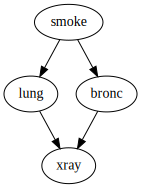

In [24]:
import graphviz as gr

edges = [('smoke', 'lung'),
         ('smoke', 'bronc'),
         ('lung', 'xray'),
         ('bronc', 'xray')]

# Create the DAG from the edges
DAG = bn.make_DAG(edges)

# Plot and make sure the arrows are correct.
def plot_from_edges(edges):
    # plot
    g = gr.Digraph()
    
    for i in range(0, len(edges)):
        g.edge(*edges[i])
    return g

g = plot_from_edges(edges)
g

<br/><br/>

At this point we have the data set in our dataframe (df), and we also have the DAG based on our expert knowledge. 
We can use parameter learning to learn conditional probability distributions (CPDs) of variales in our model. 

In [25]:
# Learn the parameters from data set.
# As input we have the DAG without CPDs.
DAG = bn.parameter_learning.fit(DAG, df, methodtype='bayes')

[bnlearn] >Removing columns from dataframe to make consistent with DAG [['tub_area' 'tub' 'either' 'dysp']]
[bnlearn] >Parameter learning> Computing parameters using [bayes]
[bnlearn] >CPD of smoke:
+----------+----------+
| smoke(0) | 0.495333 |
+----------+----------+
| smoke(1) | 0.504667 |
+----------+----------+
[bnlearn] >CPD of lung:
+---------+---------------------+---------------------+
| smoke   | smoke(0)            | smoke(1)            |
+---------+---------------------+---------------------+
| lung(0) | 0.11449721207460103 | 0.03302509907529723 |
+---------+---------------------+---------------------+
| lung(1) | 0.8855027879253989  | 0.9669749009247027  |
+---------+---------------------+---------------------+
[bnlearn] >CPD of bronc:
+----------+--------------------+--------------------+
| smoke    | smoke(0)           | smoke(1)           |
+----------+--------------------+--------------------+
| bronc(0) | 0.5919054028071524 | 0.3110020758633704 |
+----------+--------

In [26]:
# Print the CPDs
bn.print_CPD(DAG)
# At this point we have a DAG with the learned CPDs

CPD of smoke:
+----------+----------+
| smoke(0) | 0.495333 |
+----------+----------+
| smoke(1) | 0.504667 |
+----------+----------+
CPD of lung:
+---------+---------------------+---------------------+
| smoke   | smoke(0)            | smoke(1)            |
+---------+---------------------+---------------------+
| lung(0) | 0.11449721207460103 | 0.03302509907529723 |
+---------+---------------------+---------------------+
| lung(1) | 0.8855027879253989  | 0.9669749009247027  |
+---------+---------------------+---------------------+
CPD of bronc:
+----------+--------------------+--------------------+
| smoke    | smoke(0)           | smoke(1)           |
+----------+--------------------+--------------------+
| bronc(0) | 0.5919054028071524 | 0.3110020758633704 |
+----------+--------------------+--------------------+
| bronc(1) | 0.4080945971928475 | 0.6889979241366295 |
+----------+--------------------+--------------------+
CPD of xray:
+---------+---------------------+-----+----------

Now we can combined our expert knowledge with a data set! Then we can make inferences which allows us to ask causal questions from the model. Let us demonstrate a few questions...

<br>

- **Question 1:**
What is the probability of lung-cancer, given that we know that patient does smoke?

In [27]:
q1 = bn.inference.fit(DAG, variables=['lung'], evidence={'smoke':1})

[bnlearn] >Variable Elimination..
+----+--------+-----------+
|    |   lung |         p |
+====+========+===========+
|  0 |      0 | 0.0330251 |
+----+--------+-----------+
|  1 |      1 | 0.966975  |
+----+--------+-----------+


<br/><br/>

**Question 2:**
What is the probability of bronchitis, given that we know patient does smoke?

In [28]:
q2 = bn.inference.fit(DAG, variables=['bronc'], evidence={'smoke':1})

[bnlearn] >Variable Elimination..
+----+---------+----------+
|    |   bronc |        p |
+====+=========+==========+
|  0 |       0 | 0.311002 |
+----+---------+----------+
|  1 |       1 | 0.688998 |
+----+---------+----------+


<br/><br/>

**Question 3:** 
What is the probability of lung-cancer, given that we know that patient does smoke and also has bronchitis?

In [29]:
q3 = bn.inference.fit(DAG, variables=['lung'], evidence={'smoke':1, 'bronc':1})

[bnlearn] >Variable Elimination..
+----+--------+-----------+
|    |   lung |         p |
+====+========+===========+
|  0 |      0 | 0.0330251 |
+----+--------+-----------+
|  1 |      1 | 0.966975  |
+----+--------+-----------+


<br/><br/>

**Question 4:**
Lets specify the question even more. What is the probability of lung-cancer or bronchitis, given that we know that patient does smoke but did not had xray?

In [30]:
q4 = bn.inference.fit(DAG, variables=['bronc','lung'], evidence={'smoke':1, 'xray':0})

[bnlearn] >Variable Elimination..
+----+---------+--------+-----------+
|    |   bronc |   lung |         p |
+====+=========+========+===========+
|  0 |       0 |      0 | 0.0915345 |
+----+---------+--------+-----------+
|  1 |       0 |      1 | 0.226912  |
+----+---------+--------+-----------+
|  2 |       1 |      0 | 0.194173  |
+----+---------+--------+-----------+
|  3 |       1 |      1 | 0.487381  |
+----+---------+--------+-----------+


## Build a causal model when we have data and no domain knowledge

Suppose that we have the medical records of hundreds or even thousands patients treatment regarding shortness-of-breath (dyspnoea). Our goal is to determine the causality across variables given the data set. We dont have a prior knowledge. e.g. we are a dta scientist whom just start to work with the dataset.

We use structure learning to estimate the DAG structure of the dataset.

In [31]:

# Structure learning on the data set
model_estimated = bn.structure_learning.fit(df, methodtype='cs', scoretype='bic')

[bnlearn] >Computing best DAG using [cs]


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Lets plot the learned DAG and examine the structure!

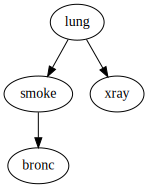

In [32]:
def plot_from_model(model):
    # plot
    g = gr.Digraph()
    
    for i in range(0, len(model_estimated['model_edges'])):
        g.edge(*model_estimated['model_edges'][i])
    return g

# Plot the DAG
plot_from_model(model_estimated)

## References
For this chapter, we used an exmaple from *bnlearn - Library for Bayesian network learning and inference*. The e-book has varius exmaples with nice visualization. Here is the ptython library [bnlearn](https://pypi.org/project/bnlearn/)

The Python bnlearn ieself is inspired by the [bnlearn - an R package for Bayesian network learning and inference](https://www.bnlearn.com) book an amazing work by Marco Scutari, IDSIA.

For causal struture search methods, we recommned this paper: [Review of Causal Discovery Methods Based on Graphical Models](https://www.frontiersin.org/articles/10.3389/fgene.2019.00524/full)